## Joint inverse design

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from pdb import set_trace as breakpoint
from time import time

import numpy as np
import matplotlib.pyplot as plt

from datasets.generators1d import * 
from datasets.generators import Cavity2D
from datasets.settings import OMEGA, MU0, EPSILON0, SCALE, C, L0, PIXEL_SIZE
from models.utils import pbar, tensor_diff, tensor_roll

In [2]:
device = torch.device('cuda:0')

In [148]:
class EpsilonTransformer(nn.Module):
    
    def __init__(self, epsilons_init, E_init, src_x = None, cavity_buffer=4):
        super().__init__()
        
        self.size = E_init.shape[0]
        if src_x is None:
            self.src_x = self.size // 4
        else:
            self.src_x = src_x
        self.cavity_buffer = cavity_buffer
        self.total_size = self.size + 2 * self.cavity_buffer
        
        self.epsilons = nn.Parameter(torch.tensor(epsilons_init), requires_grad=True)
        self.fields = nn.Parameter(torch.tensor(E_init), requires_grad=True)
        
        self.physics_weight = 1e0
        self.objective_weight = 1e-1#1e-6
            
        # store angler operators
        curl_op, eps_op = Cavity1D(device_length=self.size, cavity_buffer=self.cavity_buffer).get_operators()
        self.curl_curl_op = torch.tensor(np.asarray(np.real(curl_op)), device=device)
    
    def get_physics_residual(self):
        # Add zero field amplitudes at edge points for resonator BC's
        E = F.pad(self.fields, [self.cavity_buffer]*2)
#         E = E.view(batch_size, -1, 1)

        # Add first layer of cavity BC's
        eps = F.pad(self.epsilons, [self.cavity_buffer]*2, "constant", -1e20)
#         eps = eps.view(batch_size, -1, 1)

        # Compute Maxwell operator on fields
        curl_curl_E = (SCALE / L0**2) * torch.matmul(self.curl_curl_op, E)#.view(batch_size, -1, 1)
        epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E

#         epsilon_E = torch.bmm(self.epsilon_op, eps*E)

        # Compute free-current vector
#         J = torch.zeros(batch_size, self.total_size, self.total_size, device=device)
        J = torch.zeros_like(E, device=device)
        J[self.src_x + self.cavity_buffer] = -1.526814027933079 
#         J = J.view(batch_size, -1, 1)

        out = curl_curl_E - epsilon_E - J
#         out = out.view(batch_size, self.total_size, self.total_size)
        out = out[self.cavity_buffer:-self.cavity_buffer]
        
        return out
    
    def get_objective_residual(self):
        node_location = 50
        return (self.fields[node_location + self.cavity_buffer] - 0).view(1)
    
    def forward(self, foo): 
        physics_loss = self.physics_weight * self.get_physics_residual()
        objective_loss = self.objective_weight * self.get_objective_residual()
        out = torch.cat([physics_loss, objective_loss])
        return out

In [161]:
def epsilon_transform(epsilons, src_x=16, target_loss=1e-6, max_epochs=1e4):

    cavity_buffer = 4
    _, _, _, _, Ez = Cavity1D(device_length=len(epsilons), cavity_buffer=cavity_buffer).solve(epsilons, omega=OMEGA_1550, src_x=src_x)

    E_init = np.real(Ez[cavity_buffer:-cavity_buffer])
    model = EpsilonTransformer(epsilons, E_init, cavity_buffer=cavity_buffer).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    epochs = 0
    loss=1e10
    model.train()
    p = pbar(total=max_epochs)
    while loss > target_loss and epochs <= max_epochs:
        epochs += 1
        outputs = model(None)
        loss = criterion(outputs, torch.zeros_like(outputs))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        p.update()
        p.set_description("ℒ = {:.1e}".format(loss.item()), refresh=False)

    p.close()

    model.eval()        
    return model, model.fields.cpu().detach().numpy(), model.epsilons.cpu().detach().numpy()

In [162]:
epsilons = perm_random_number_alternating_layers()
model, fields, eps = epsilon_transform(epsilons)

In [163]:
epsilons - eps

array([ 2.15088235e-02,  4.37718726e-02,  4.25945922e-02,  3.47240102e-03,
       -2.32611501e-02,  5.61986451e-03,  4.85762966e-02,  6.76920467e-02,
        9.66438356e-02,  8.33122191e-02,  6.45059685e-02,  5.75134720e-02,
        4.72054161e-02,  2.80592172e-02, -2.51681420e-02,  5.78153883e-02,
        4.41194286e-02,  4.88264693e-03,  4.34910236e-02,  5.67355368e-02,
        5.48832856e-02, -5.26036313e-02,  5.25891570e-02,  7.93174589e-02,
        4.98374991e-02, -1.58163559e-02,  7.43210213e-02,  7.80350139e-02,
       -6.82917040e-03, -1.11200519e-01, -1.91982773e-01, -2.92173051e-01,
        3.76063014e-02,  8.05025731e-01,  3.30724034e+00,  5.38257083e+00,
        5.10525089e+00, -6.93259239e+00, -2.59754648e+00,  6.51733558e+00,
        6.14801428e+00, -7.11864664e+00, -5.37542772e+00,  5.49361754e+00,
        5.09645856e+00, -8.01913084e+00, -4.75986535e+00,  1.61608058e+00,
        5.41720911e+00, -9.72419068e+00, -4.17448391e+00,  6.66916034e-02,
        5.03087972e+00,  

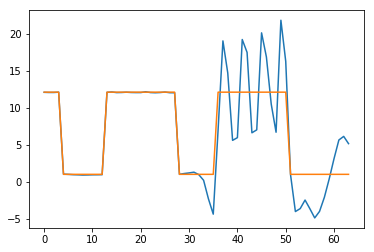

In [164]:
plt.plot(eps)
plt.plot(epsilons)
plt.show()

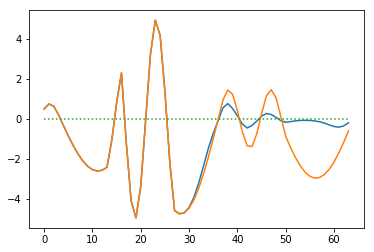

In [165]:
_, _, _, _, Ez = Cavity1D(device_length=len(epsilons), cavity_buffer=cavity_buffer).solve(epsilons, omega=OMEGA_1550, src_x=src_x)
E_init = np.real(Ez[cavity_buffer:-cavity_buffer])
# plt.plot(fields-E_init)
plt.plot(fields)
plt.plot(E_init)
plt.plot(np.zeros(fields.shape), linestyle=':')
plt.show()

In [146]:
fields[54]

0.587747781818845

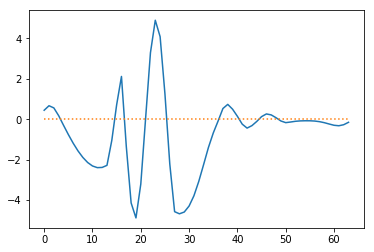

In [166]:
_, _, _, _, Ez = Cavity1D(device_length=len(epsilons), cavity_buffer=cavity_buffer).solve(eps, omega=OMEGA_1550, src_x=src_x)
# plt.plot(fields-E_init)
plt.plot(np.real(Ez[cavity_buffer:-cavity_buffer]))
plt.plot(np.zeros(fields.shape), linestyle=':')
plt.show()